# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

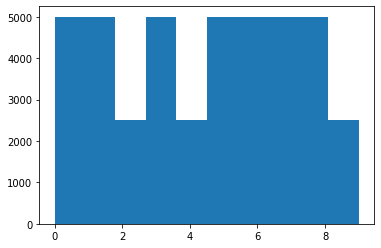

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Load AE models weight

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [11]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [12]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output) # 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 7
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128

    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 8
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 9
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x) # 11
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x) # 12

    return Model(input_img, y)

#### Train without data augumentation 

In [13]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model01 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_030_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model01_history = model01.fit(x_train_, y_train_onehot,
                          batch_size=32,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_, y_valid_onehot),
                          callbacks=[es_cb, cp_cb],
                          shuffle=True)
    
    # inference
    model01.load_weights(chkpt)
    scores = model01.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model01.metrics_names[0]} of {scores[0]}; {model01.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model01.predict(x_test)
    predicts += predict
    
    histories.append(model01_history.history)
    fold_no += 1

Epoch 1/400
886/886 [==============================] - ETA: 0s - loss: 1.5105 - accuracy: 0.4520
Epoch 00001: val_loss improved from inf to 1.88042, saving model to ../models/CNN\Model_030_1_Best.hdf5
886/886 [==============================] - 10s 12ms/step - loss: 1.5105 - accuracy: 0.4520 - val_loss: 1.8804 - val_accuracy: 0.4540
Epoch 2/400
883/886 [============================>.] - ETA: 0s - loss: 1.1077 - accuracy: 0.6109
Epoch 00002: val_loss improved from 1.88042 to 1.13003, saving model to ../models/CNN\Model_030_1_Best.hdf5
886/886 [==============================] - 10s 11ms/step - loss: 1.1069 - accuracy: 0.6112 - val_loss: 1.1300 - val_accuracy: 0.6076
Epoch 3/400
886/886 [==============================] - ETA: 0s - loss: 0.8353 - accuracy: 0.7143
Epoch 00003: val_loss improved from 1.13003 to 0.94419, saving model to ../models/CNN\Model_030_1_Best.hdf5
886/886 [==============================] - 10s 11ms/step - loss: 0.8353 - accuracy: 0.7143 - val_loss: 0.9442 - val_accurac

Epoch 7/400
882/886 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8723
Epoch 00007: val_loss did not improve from 0.66929
886/886 [==============================] - 10s 11ms/step - loss: 0.3667 - accuracy: 0.8724 - val_loss: 0.7235 - val_accuracy: 0.7735
Epoch 8/400
881/886 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8964
Epoch 00008: val_loss did not improve from 0.66929
886/886 [==============================] - 10s 11ms/step - loss: 0.2972 - accuracy: 0.8966 - val_loss: 0.7465 - val_accuracy: 0.7726
Epoch 9/400
886/886 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9194
Epoch 00009: val_loss did not improve from 0.66929
886/886 [==============================] - 10s 11ms/step - loss: 0.2323 - accuracy: 0.9194 - val_loss: 0.7862 - val_accuracy: 0.7694
Epoch 00009: early stopping
313/313 [==============================] - 1s 3ms/step - loss: 0.7439 - accuracy: 0.7600
Score for fold 3: loss of 0.743902981281

In [14]:
ensemble_histories = histories
ensemble_predicts = predicts
ensemble_predicts_ = ensemble_predicts / n_splits
y_pred = np.argmax(ensemble_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.89      0.95      0.92      1000
           2       0.88      0.57      0.69      1000
           3       0.68      0.70      0.69      1000
           4       0.76      0.83      0.79      1000
           5       0.81      0.73      0.77      1000
           6       0.78      0.91      0.84      1000
           7       0.84      0.90      0.87      1000
           8       0.83      0.94      0.88      1000
           9       0.95      0.81      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



#### Train with data augumentation

In [15]:
# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model02 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_031_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10,
#         shear_range=0.2,
        horizontal_flip=True,
#         vertical_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
        zoom_range=0.1
#         channel_shift_range=0.2
        )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model02_history = model02.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model02.load_weights(chkpt)
    scores = model02.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model02.metrics_names[0]} of {scores[0]}; {model02.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model02.predict(x_test)
    predicts += predict
    
    histories.append(model02_history.history)
    fold_no += 1

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
882/885 [============================>.] - ETA: 0s - loss: 1.5639 - accuracy: 0.4380
Epoch 00001: val_loss improved from inf to 1.81706, saving model to ../models/CNN\Model_031_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.5636 - accuracy: 0.4382 - val_loss: 1.8171 - val_accuracy: 0.4501
Epoch 2/400
884/885 [============================>.] - ETA: 0s - loss: 1.1285 - accuracy: 0.6037
Epoch 00002: val_loss improved from 1.81706 to 1.29928, saving model to ../models/CNN\Model_031_1_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 1.1282 - accuracy: 0.6039 - val_loss: 1.2993 - val_accuracy: 0.5592
Epoch 3/400
880/885 [============================>.] - ETA: 0s - loss: 0.8934 - accuracy: 0.6879
Epoch 00003: val_loss improved from 1.29928 to 0.89240, saving model to ../models/CNN\Model_031_1_Best.hdf5
885/885 [==============================] - 10s 

Epoch 10/400
882/885 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8633
Epoch 00010: val_loss improved from 0.57813 to 0.54280, saving model to ../models/CNN\Model_031_2_Best.hdf5
885/885 [==============================] - 10s 12ms/step - loss: 0.3985 - accuracy: 0.8634 - val_loss: 0.5428 - val_accuracy: 0.8208
Epoch 11/400
883/885 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8730
Epoch 00011: val_loss improved from 0.54280 to 0.52544, saving model to ../models/CNN\Model_031_2_Best.hdf5
885/885 [==============================] - 10s 11ms/step - loss: 0.3640 - accuracy: 0.8730 - val_loss: 0.5254 - val_accuracy: 0.8259
Epoch 12/400
881/885 [============================>.] - ETA: 0s - loss: 0.3295 - accuracy: 0.8839
Epoch 00012: val_loss did not improve from 0.52544
885/885 [==============================] - 10s 12ms/step - loss: 0.3300 - accuracy: 0.8839 - val_loss: 0.5587 - val_accuracy: 0.8183
Epoch 13/400
884/885 [==================

In [18]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       0.94      0.96      0.95      1000
           2       0.80      0.81      0.80      1000
           3       0.81      0.72      0.76      1000
           4       0.88      0.82      0.85      1000
           5       0.84      0.80      0.82      1000
           6       0.87      0.92      0.90      1000
           7       0.83      0.95      0.89      1000
           8       0.96      0.90      0.93      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

